## Adjusting threshold

The idea is to show that undersampling (u) is more or less equivalent to no undersampling but selecting the appropriate threshold when calling a heat wave. The run we will work with is in the directory:

training/__folder.France_equalmixed_22by128__/stack_CNN_equalmix_ckpt_t2mFrance__with_zg500_t2mmrsoFrance__22by128_u10o1_LONG8000yrs__per_5_tau_


Between the runs the data should be handled equivalently up to the undersampling stage. In other words X should be the same (it will also depend on tau). The undersampling only affects the train set which we don't care about, so ,in principle, either of the trained models can be applied to X.

In [1]:
%%time
# George Miloshevich 2021
# Perform training

# Importation des librairies
import os as os
import sys
sys.path.insert(1, '../ERA')
from ERA_Fields import* # general routines
from TF_Fields import* # tensorflow routines 
import time
import shutil
import gc
import psutil
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
from operator import mul
from functools import reduce

def custom_CNN(model_input_dim): # This CNN I took from https://www.tensorflow.org/tutorials/images/cnn
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), input_shape=model_input_dim))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(SpatialDropout2D(0.2))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(SpatialDropout2D(0.2))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(SpatialDropout2D(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(2))
    return model


def probability_model(inputs,input_model): # This function is used to apply softmax to the output of the neural network
    x = input_model(inputs)
    outputs = layers.Softmax()(x)
    return keras.Model(inputs, outputs)

def CNN_layers(input_1):# This CNN is inspired by https://www.tensorflow.org/tutorials/images/cnn
    x = layers.Conv2D(32, (3, 3))(input_1)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = SpatialDropout2D(0.2)(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = SpatialDropout2D(0.2)(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = SpatialDropout2D(0.2)(x)
    return layers.Flatten()(x)

def bottom_layers(input_1):
    x = layers.Dense(64, activation='relu')(input_1)
    x = layers.Dropout(0.2)(x)
    return layers.Dense(2)(x)


from tensorflow.keras.regularizers import l2
import math
def create_regularized_model(factor, rate, inputshape=(1,)):
    model = tf.keras.models.Sequential([
        #tf.keras.layers.Flatten(input_shape=(8, 8)),     # if the model has a tensor input
        tf.keras.layers.Input(shape=inputshape),                 # if the model has a flat input
        tf.keras.layers.Dense(2, kernel_regularizer=l2(factor))
    ])
    return model


sampling='' #'3hrs' # This chooses whether we want say daily sampling or 3 hour one. Notice that the corresponding NetCDF files are kept in different places
creation = 'training/__folder.France14_equalmixed_22by128__/CNN_eqlmxd_ckpt_t2mT14France__with_zg500_t2mmrsoFrance__u1o1_8000yrs__per_5_finetune_tau_0'
percent = 5 # 1 

timesperday = 8 # 3 hour long periods in case we choose this sampling
if sampling == '3hrs':
    T = 14*timesperday
else:
    T = 14

tau = 0 #-5  # lag
usepipelines = False # if True => Dataset.from_tensor_slices will be used. This is a more advanced method but it takes more RAM and there is a possiblity for memory leaks when repeating training for cross-validation
fullmetrics = True # If True MCC and confusion matrix will be evaluated during training. This makes training slower!

Model = 'Plasim'
area = 'France'
lon_start = 0
lon_end = 128
lat_start = 0 # latitudes start from 90 degrees North Pole
lat_end = 22


#myscratch='/scratch/gmiloshe/PLASIM/'  # where we acess .py files and save output
mylocal='/local/gmiloshe/PLASIM/' #'/local/gmiloshe/PLASIM/'      # where we keep large datasets that need to be loaded
myscratch=TryLocalSource(mylocal)        # Check if the data is not there and can be found in some other source
#myscratch=mylocal

new_mixing = False                     # if set to True the undersampling will also follow the suit

num_years = 8000                       # Select the number of years from the simulation for the analysis


# If an integer >= 1 is chosen we simply undersample by this rate
# If a float between 0 and 1 is chosen we select each state with the probability given by this float
undersampling_factor = 1 # 1 #15 #10 #5 #1 #0.25 #0.15 #0.25
oversampling_factor = 1 # oversampling_factor = 1 means that oversampling will not be performed
thefield = 't2m' # Important: this is the field that is used to determine the extrema (important for undersampling) and therefore the label space
BATCH_SIZE = 1024 # choose this for training so that the chance of encountering positive batches is nonnegligeable
NUM_EPOCHS = 20 #100 #1000 #20 #200 #50 # number of epochs the training involves
saveweightseveryblaepoch = 1 # If set to 0 the model will not save weights as it is being trained, otherwise this number will tell us how many epochs it weights until saving
if saveweightseveryblaepoch > 0:
    ckpt = 'ckpt'
else:
    cktp = ''

    
print("creation = ", creation)

#lat_from = [4,4]     # 18x42
#lat_to   = [22,22]
#lon_from = [101,0]
#lon_to   = [128,15]
lat_from =  [0,0]   # 22x128
lat_to =    [22,22]
lon_from =  [64, 0]
lon_to =    [128, 64]


print([percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield])

if sampling == '3hrs':
    Months1 = [0, 0, 0, 0, 0, 0, timesperday*30, timesperday*30, timesperday*30, timesperday*30, timesperday*30, 0, 0, 0]
else: # if sampling == 'daily'
    Months1 = [0, 0, 0, 0, 0, 0, 30, 30, 30, 30, 30, 0, 0, 0] 
Tot_Mon1 = list(itertools.accumulate(Months1))

time_start = Tot_Mon1[6]
time_end = Tot_Mon1[9] #+(Tot_Mon1[10]-Tot_Mon1[9])//2   # uncomment this if we are to use full summer (including the portion with september due to T days window)

if sampling == '3hrs': 
    prefix = ''
    file_prefix = '../Climate/'
else:
    prefix = 'ANO_LONG_'
    file_prefix = ''

t2m = Plasim_Field('tas',prefix+'tas','Temperature', Model, lat_start, lat_end, lon_start, lon_end,'single',sampling)     # if we want to use surface tempeature
zg500 = Plasim_Field('zg',prefix+'zg500','500 mbar Geopotential', Model, lat_start, lat_end, lon_start, lon_end,'single',sampling)
#zg300 = Plasim_Field('zg',prefix+'zg300','300 mbar Geopotential', Model, lat_start, lat_end, lon_start, lon_end,'single',sampling)
mrso = Plasim_Field('mrso',prefix+'mrso','soil moisture', Model, lat_start, lat_end, lon_start, lon_end,'single',sampling)
#ua300 = Plasim_Field('ua',prefix+'ua300','eastward wind', Model, lat_start, lat_end, lon_start, lon_end,'single',sampling)
#va300 = Plasim_Field('va',prefix+'va300','northward wind', Model, lat_start, lat_end, lon_start, lon_end,'single',sampling)
#hfls = Plasim_Field('hfls',prefix+'hfls','surface latent heat flux', Model, lat_start, lat_end, lon_start, lon_end,'single',sampling)
#hfss = Plasim_Field('hfss',prefix+'hfss','surface sensible heat flux', Model, lat_start, lat_end, lon_start, lon_end,'single',sampling)

t2m.years=8000
zg500.years=8000
mrso.years=8000

#ts.load_field(mylocal+file_prefix+'Data_Plasim/')  # load the data
t2m.load_field(mylocal+file_prefix+'Data_Plasim_LONG/')  # load the data
zg500.load_field(mylocal+file_prefix+'Data_Plasim_LONG/')
#zg300.load_field(mylocal+file_prefix+'Data_Plasim/')
mrso.load_field(mylocal+file_prefix+'Data_Plasim_LONG/')
#ua300.load_field(mylocal+file_prefix+'Data_Plasim/')
#va300.load_field(mylocal+file_prefix+'Data_Plasim/')
#hfls.load_field(mylocal+file_prefix+'Data_Plasim/')
#hfss.load_field(mylocal+file_prefix+'Data_Plasim/')

LON = t2m.LON
LAT = t2m.LAT
print(t2m.var.dtype,t2m.var.dtype,t2m.var.dtype)

mask, cell_area, lsm = ExtractAreaWithMask(mylocal,Model,area) # extract land sea mask and multiply it by cell area
print(mask)

#ts.abs_area_int, ts.ano_area_int = ts.Set_area_integral(area,mask)
t2m.abs_area_int, t2m.ano_area_int = t2m.Set_area_integral(area,mask,'PostprocLONG')
zg500.abs_area_int, zg500.ano_area_int = zg500.Set_area_integral(area,mask,'PostprocLONG') 
#zg300.abs_area_int, zg300.ano_area_int = zg300.Set_area_integral(area,mask) 
mrso.abs_area_int, mrso.ano_area_int = mrso.Set_area_integral(area,mask,'PostprocLONG')
#ua300.abs_area_int, ua300.ano_area_int = ua300.Set_area_integral(area,mask) 
#va300.abs_area_int, va300.ano_area_int = va300.Set_area_integral(area,mask)
#hfls.abs_area_int, hfls.ano_area_int = hfls.Set_area_integral(area,mask) 
#hfss.abs_area_int, hfss.ano_area_int = hfss.Set_area_integral(area,mask)


# ===Below we filter out just the area of France for mrso====

filter_mask = np.zeros((t2m.var.shape[2],t2m.var.shape[3])) # a mask which sets to zero all values
filter_lat_from = [13, 13]  # defining the domain of 1's
filter_lat_to = [17, 17] 
filter_lon_from = [-1, 0] 
filter_lon_to =  [128, 3] 

for myiter in range(len(filter_lat_from)): # seting values to 1 in the desired domain
        filter_mask[filter_lat_from[myiter]:filter_lat_to[myiter],filter_lon_from[myiter]:filter_lon_to[myiter]] = 1

mrso.var = mrso.var*filter_mask # applying the filter to set to zero all values outside the domain
    
    

filename_mixing = t2m.PreMixing(new_mixing,creation,num_years) # load from the folder that we are calling this file from   # NEW MIXING MEANS ALSO NEW UNDERSAMPLING!
zg500.PreMixing(False,creation,num_years) # IT IS IMPORTANT THAT ALL SUBSEQUENT FIELDS BE MIXED (SHUFFLED) THE SAME WAY, otherwise no synchronization!
#zg300.PreMixing(False,creation,num_years)
mrso.PreMixing(False,creation,num_years)
print("t2m.var.shape = ", t2m.var.shape)
print("time_end = ", time_end, " ,time_start = ", time_start, " ,T = ", T)

A, A_reshape, threshold, list_extremes, convseq =  t2m.ComputeTimeAverage(time_start,time_end,T,tau, percent)
print("threshold = ",threshold)


filename_mixing = t2m.EqualMixing(A, threshold, new_mixing,creation,num_years)
zg500.EqualMixing(A, threshold, False,creation,num_years)
#zg300.EqualMixing(A, threshold, False,creation,num_years)
mrso.EqualMixing(A, threshold, False,creation,num_years)
# Now we have to recompute the extremes:

A, A_reshape, threshold, list_extremes, convseq =  t2m.ComputeTimeAverage(time_start,time_end,T,tau, percent)

# ===== Applying filter to the temperature field: ====
t2m.var = t2m.var*filter_mask # applying the filter to set to zero all values outside the domain

print("threshold = ",threshold)
print(A.dtype)
# Below we reshape into time by flattened array
t2m.abs_area_int_reshape = t2m.ReshapeInto1Dseries(area, mask, Tot_Mon1[6], Tot_Mon1[9], T, tau)
mrso.abs_area_int_reshape = mrso.ReshapeInto1Dseries(area, mask, Tot_Mon1[6], Tot_Mon1[9], T, tau)
print("mrso.abs_area_int_reshape.shape = ", mrso.abs_area_int_reshape.shape)

print("t2m.var.shape = ", t2m.var.shape)


Trying to import basemap
Successfully imported basemap


2021-12-30 07:44:55.173892: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


addresswithoutlocal = 'gmiloshe/PLASIM/'
Trying source:  /ClimateDynamics/MediumSpace/ClimateLearningFR/
The source will be:  /ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/PLASIM/
creation =  training/__folder.France14_equalmixed_22by128__/CNN_eqlmxd_ckpt_t2mT14France__with_zg500_t2mmrsoFrance__u1o1_8000yrs__per_5_finetune_tau_0
[5, 14, 'Plasim', 'France', 1, [0, 0], [22, 22], [64, 0], [128, 64], 't2m']
Loading field tas
Loaded time array
input self.var.shape = (1200000, 22, 128)
output self.var.shape = (8000, 150, 22, 128)
self.time.shape = (8000, 150)
24.0  < np.diff(self.time) <  24.0
Loading field zg
Loaded time array
input self.var.shape = (1200000, 22, 128)
output self.var.shape = (8000, 150, 22, 128)
self.time.shape = (8000, 150)
24.0  < np.diff(self.time) <  24.0
Loading field mrso
Loaded time array
input self.var.shape = (1200000, 22, 128)
output self.var.shape = (8000, 150, 22, 128)
self.time.shape = (8000, 150)
24.0  < np.diff(self.time) <  24.0
float32 float32 flo

From here on we have to select the appropriate X which depends on $tau$

In [7]:
%%time
tau = -30
checkpoint_name = creation[:-1]+str(tau)
 # =================Use this if many fields need to be used:============
    
Xs = [t2m.ReshapeInto2Dseries(time_start, time_end,lat_from1,lat_to1,lon_from1,lon_to1,T,tau,dim=2) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)] # here we extract the portion of the globe
X = np.concatenate(Xs, axis=2)


## Without Coarse Graining:
Xs = [zg500.ReshapeInto2Dseries(time_start, time_end,lat_from1,lat_to1,lon_from1,lon_to1,T,tau,dim=2) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)] # here we extract the portion of the globe
X= np.concatenate([X[:,:,:,np.newaxis], np.concatenate(Xs, axis=2)[:,:,:,np.newaxis]], axis=3)

Xs = [mrso.ReshapeInto2Dseries(time_start, time_end,lat_from1,lat_to1,lon_from1,lon_to1,T,tau,dim=2) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)] # here we extract the portion of the globe
X= np.concatenate([X, np.concatenate(Xs, axis=2)[:,:,:,np.newaxis]], axis=3)
print("X.shape = ", X.shape)

X.shape =  (616000, 22, 128, 3)
CPU times: user 48.6 s, sys: 1min 6s, total: 1min 55s
Wall time: 1min 55s


We look for the optimal checkpoint which corresponds to the minimum in the average Reconstructed Skill (CustomLoss)

			'val_CustomLoss' in history.keys()
		========Optimal checkpoint =  0


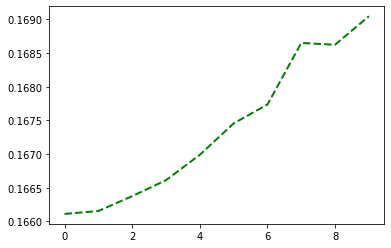

In [8]:
maxskill = -(percent/100.)*np.log(percent/100.)-(1-percent/100.)*np.log(1-percent/100.)
history = np.load(checkpoint_name+'/batch_'+str(0)+'_history.npy', allow_pickle=True).item()
if ('val_CustomLoss' in history.keys()):
    print( "\t\t\t'val_CustomLoss' in history.keys()")
    historyCustom = []
    for i in range(10): # preemptively compute the optimal score
        historyCustom.append(np.load(checkpoint_name+'/batch_'+str(i)+'_history.npy', allow_pickle=True).item()['val_CustomLoss'])
    historyCustom = np.mean(np.array(historyCustom),0)
    opt_checkpoint = np.argmin(historyCustom)+1 # We will use optimal checkpoint in this case!

print("\t\t========Optimal checkpoint = ", opt_checkpoint)


plt.plot(historyCustom, 'g--', linewidth = 2, label ='train average')

The next step is to compute the various metrics as a function of a folds (10) and as a function of the effective undersampling factor the user provides. This will be done for $$\tau = -30$$

Normally the checkpoint has to be 0 (according to history), that's because history includes the initial weights. Here we will set to 1 to compare the results of the current computation to the results we see in the 
vim training/__folder.France14_equalmixed_22by128__/CNN_eqlmxd_ckpt_t2mT14France__with_zg500_t2mmrsoFrance__u1o1_8000yrs__per_5_finetune_tau_-30/logger.loglogfile.log

In [39]:
opt_checkpoint=1

In [37]:
%%time


undersampling_factors=10**np.arange(-3,2,.1)
new_MCC = np.zeros((10,50))
new_entropy = np.zeros((10,50))
new_BS = np.zeros((10,50))
new_WBS = np.zeros((10,50))
new_freq = np.zeros((10,50))
new_skill = np.zeros((10,50))
new_TP = np.zeros((10,50))
new_FP = np.zeros((10,50))
new_TN = np.zeros((10,50))
new_FN = np.zeros((10,50))

mylabels = np.array(list_extremes)
model = tf.keras.models.load_model(checkpoint_name+'/batch_'+str(0), compile=False) # if we just want to train
tf_sampling = tf.cast([0.5*np.log(undersampling_factor), -0.5*np.log(undersampling_factor)], tf.float32)
model.summary()
METRICS=['accuracy',MCCMetric(2),ConfusionMatrixMetric(2),CustomLoss(tf_sampling)]#tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)]#CustomLoss()]   # the last two make the code run longer but give precise discrete prediction benchmarks
model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate = 2e-4),
            #optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #If the predicted labels are not converted to a probability distribution by the last layer of the model (using sigmoid or softmax activation functions), we need to inform these three Cross-Entropy functions by setting their from_logits = True.
            #One advantage of using sparse categorical cross-entropy is it saves storage in memory as well as time in computation because it simply uses a single integer for a class, rather than a whole one-hot vector. This works despite the fact that the neural network has an one-hot vector output  
            metrics=METRICS   # the last two make the code run longer but give precise discrete prediction benchmarks
        )
modelevaluate = []
for i in range(10):
    print("\t\t\t===============================")
    print("\t\t\tcross validation i = ", str(i))

    X_test, Y_test, X_mean, X_std, test_indices = NormalizeAndX_test(i, X, mylabels, 1, sampling, new_mixing, thefield, percent, checkpoint_name)

    nb_zeros_c = 4-len(str(opt_checkpoint))
    checkpoint_name_batch = '/cp-'+nb_zeros_c*'0'+str(opt_checkpoint)+'.ckpt'
    model.load_weights(checkpoint_name+'/batch_'+str(i)+checkpoint_name_batch)
    my_probability_model=(tf.keras.Sequential([ # softmax output to make a prediction
              model,
              tf.keras.layers.Softmax()
            ]))
    Y_pred_prob = my_probability_model.predict(X_test)
    #Y_pred, Y_pred_prob = ModelToProb(X,X_test,model)
    modelevaluate.append(model.evaluate(X_test, Y_test))
    for j in range(50):
        undersampling_factor = undersampling_factors[j]
        new_MCC[i,j], new_entropy[i,j], new_skill[i,j], new_BS[i,j], new_WBS[i,j], new_freq[i,j]  = ComputeMetrics(Y_test, Y_pred_prob, percent, undersampling_factor)


        Y_pred_prob_renorm = ReNormProbability(Y_pred_prob, undersampling_factor)
        label_assignment = np.argmax(Y_pred_prob_renorm,1)

        new_TP[i,j], new_TN[i,j], new_FP[i,j], new_FN[i,j], MCC = ComputeMCC(Y_test, label_assignment, False)
    #print("MCC = " , new_MCC[i]," ,entropy = ", new_entropy[i], " ,entropy = ", -np.sum(np.c_[1-Y_test,Y_test]*np.log(Y_pred_prob))/Y_test.shape[0], " ,BS = ", new_BS[i], " , WBS = ", new_WBS[i], " , freq = ", new_freq[i])
#print("\t\t"+f" TOTAL MCC  = {np.mean(new_MCC):.3f} +- {np.std(new_MCC):.3f} , entropy = {np.mean(new_entropy):.3f} +- {np.std(new_entropy):.3f} , skill = {np.mean(new_skill):.3f} +- {np.std(new_skill):.3f}, Brier = {np.mean(new_BS):.3f} +- {np.std(new_BS):.3f} , Weighted Brier = {np.mean(new_WBS):.3f} +- {np.std(new_WBS):.3f} , frequency = {np.mean(new_freq):.3f} +- {np.std(new_freq):.3f}")



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 126, 32)       896       
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 126, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 20, 126, 32)       0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 20, 126, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 61, 64)         18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 61, 64)         2

Next we output the computed entropy and MCC at batch = 0 which seems to be consistent with the output saved in 
 training/__folder.France14_equalmixed_22by128__/CNN_eqlmxd_ckpt_t2mT14France__with_zg500_t2mmrsoFrance__u1o1_8000yrs__per_5_finetune_tau_-30/logger.loglogfile.log
 
 at batch = 0 epoch = 1

In [47]:
new_entropy[0,30], new_MCC[0,30]

(0.16193290857382142, 0.0)

Below we write the output of the computation above with model.predict as well as model.evaluate and again both are in agreement with what we have in the log file

In [49]:
str(np.mean(new_entropy[:,30]))+'+-'+str(np.std(new_entropy[:,30])), str(np.mean([modelevaluate[i][0] for i in range(10)]))+'+-'+str(np.std([modelevaluate[i][0] for i in range(10)]))

('0.16611141558112077+-0.0030827365867366853',
 '0.16611144095659255+-0.003082685607178693')

In [50]:
str(np.mean(new_MCC[:,30]))+'+-'+str(np.std(new_MCC[:,30])), str(np.mean([modelevaluate[i][2] for i in range(10)]))+'+-'+str(np.std([modelevaluate[i][2] for i in range(10)]))

('0.0014406663509997195+-0.005411266952003917',
 '0.0014406663016416133+-0.005411266814857954')

These results are actually consistent with the output of Recalc_Tau_Metrics.py, which says it works with opt_checkpoint = 0 (which is obtained by the same minimization procedure). But in practice it seems the value 1 was used

(0.0, 0.5)

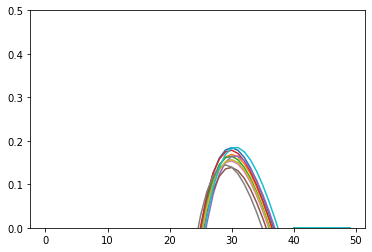

In [52]:
plt.plot(new_skill.transpose())
plt.ylim([0, .5])

In [53]:
undersampling_factors[np.argmax(np.mean(new_skill,0))]

1.0000000000000062

(0.0, 0.5)

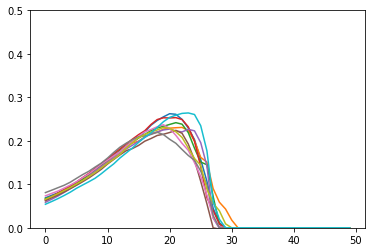

In [54]:
plt.plot(new_MCC.transpose())
plt.ylim([0, .5])

In [55]:
undersampling_factors[np.argmax(np.mean(new_MCC,0))]

0.10000000000000041

Now we add all tau

In [79]:
np.savez(creation+'/new_vars', new_MCC, new_entropy, new_BS, new_WBS, new_freq, new_skill, new_TP, new_FP, new_TN, new_FN, new_TPR, new_PPV, new_FPR, new_F1)

In [81]:
%%time
undersampling_factors=10**np.arange(-3,2,.1)
taus = range(0,-35,-5)
new_MCC = np.zeros((len(taus),10,undersampling_factors.shape[0]))
new_entropy = np.zeros((len(taus),10,undersampling_factors.shape[0]))
new_BS = np.zeros((len(taus),10,undersampling_factors.shape[0]))
new_WBS = np.zeros((len(taus),10,undersampling_factors.shape[0]))
new_freq = np.zeros((len(taus),10,undersampling_factors.shape[0]))
new_skill = np.zeros((len(taus),10,undersampling_factors.shape[0]))
new_TP = np.zeros((len(taus),10,undersampling_factors.shape[0]))
new_FP = np.zeros((len(taus),10,undersampling_factors.shape[0]))
new_TN = np.zeros((len(taus),10,undersampling_factors.shape[0]))
new_FN = np.zeros((len(taus),10,undersampling_factors.shape[0]))
for itau, tau in enumerate(taus):
    checkpoint_name = creation[:-1]+str(tau)
     # =================Use this if many fields need to be used:============

    Xs = [t2m.ReshapeInto2Dseries(time_start, time_end,lat_from1,lat_to1,lon_from1,lon_to1,T,tau,dim=2) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)] # here we extract the portion of the globe
    X = np.concatenate(Xs, axis=2)


    ## Without Coarse Graining:
    Xs = [zg500.ReshapeInto2Dseries(time_start, time_end,lat_from1,lat_to1,lon_from1,lon_to1,T,tau,dim=2) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)] # here we extract the portion of the globe
    X= np.concatenate([X[:,:,:,np.newaxis], np.concatenate(Xs, axis=2)[:,:,:,np.newaxis]], axis=3)

    Xs = [mrso.ReshapeInto2Dseries(time_start, time_end,lat_from1,lat_to1,lon_from1,lon_to1,T,tau,dim=2) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)] # here we extract the portion of the globe
    X= np.concatenate([X, np.concatenate(Xs, axis=2)[:,:,:,np.newaxis]], axis=3)
    print("X.shape = ", X.shape)
    maxskill = -(percent/100.)*np.log(percent/100.)-(1-percent/100.)*np.log(1-percent/100.)
    history = np.load(checkpoint_name+'/batch_'+str(0)+'_history.npy', allow_pickle=True).item()
    if ('val_CustomLoss' in history.keys()):
        print( "\t\t\t'val_CustomLoss' in history.keys()")
        historyCustom = []
        for i in range(10): # preemptively compute the optimal score
            historyCustom.append(np.load(checkpoint_name+'/batch_'+str(i)+'_history.npy', allow_pickle=True).item()['val_CustomLoss'])
        historyCustom = np.mean(np.array(historyCustom),0)
        opt_checkpoint = np.argmin(historyCustom)+1 # We will use optimal checkpoint in this case!

    print("\t\t========Optimal checkpoint = ", opt_checkpoint)

    mylabels = np.array(list_extremes)
    model = tf.keras.models.load_model(checkpoint_name+'/batch_'+str(0), compile=False) # if we just want to train

    for i in range(10):
        print("\t\t\t===============================")
        print("\t\t\tcross validation i = ", str(i))

        X_test, Y_test, X_mean, X_std, test_indices = NormalizeAndX_test(i, X, mylabels, 1, sampling, new_mixing, thefield, percent, checkpoint_name)

        nb_zeros_c = 4-len(str(opt_checkpoint))
        checkpoint_name_batch = '/cp-'+nb_zeros_c*'0'+str(opt_checkpoint)+'.ckpt'
        model.load_weights(checkpoint_name+'/batch_'+str(i)+checkpoint_name_batch)
        my_probability_model=(tf.keras.Sequential([ # softmax output to make a prediction
                  model,
                  tf.keras.layers.Softmax()
                ]))
        Y_pred_prob = my_probability_model.predict(X_test)
        #Y_pred, Y_pred_prob = ModelToProb(X,X_test,model)

        for j in range(undersampling_factors.shape[0]):
            undersampling_factor = undersampling_factors[j]
            new_MCC[itau,i,j], new_entropy[itau,i,j], new_skill[itau,i,j], new_BS[itau,i,j], new_WBS[itau,i,j], new_freq[itau,i,j]  = ComputeMetrics(Y_test, Y_pred_prob, percent, undersampling_factor)


            Y_pred_prob_renorm = ReNormProbability(Y_pred_prob, undersampling_factor)
            label_assignment = np.argmax(Y_pred_prob_renorm,1)

            new_TP[itau,i,j], new_TN[itau,i,j], new_FP[itau,i,j], new_FN[itau,i,j], MCC = ComputeMCC(Y_test, label_assignment, False)
new_TPR = new_TP/(new_TP+new_FN)
new_PPV = new_TP/(new_TP+new_FP)
new_FPR = new_FP/(new_FP+new_TN)
new_F1 = 2*new_TP/(2*new_TP+new_FP+new_TN)
np.savez(creation+'/new_vars', new_MCC, new_entropy, new_BS, new_WBS, new_freq, new_skill, new_TP, new_FP, new_TN, new_FN, new_TPR, new_PPV, new_FPR, new_F1)

X.shape =  (616000, 22, 128, 3)
			'val_CustomLoss' in history.keys()
		========Optimal checkpoint =  10
			cross validation i =  0
initial lower =  0  , initial upper =  61600
 train_false_labels_indices.shape[0] =  526680
MCC =  0.2397780828821089  , TP =  3062  , TN =  32484  , FP =  26036  , FN =  18
renorm =  0.001 , MCC =  0.2397780828821089  ,entropy =  1.415735994603237  ,entropy =  1.415735994603237  , skill =  -6.131623600997753  ,BS =  0.35035276734983767  , WBS =  0.18638954427469545  , freq =  0.4723701298701299
MCC =  0.24758004898780772  , TP =  3059  , TN =  33507  , FP =  25013  , FN =  21
renorm =  0.0012589254117941675 , MCC =  0.24758004898780772  ,entropy =  1.3212226881733833  ,entropy =  1.3212226881733833  , skill =  -5.655522598188696  ,BS =  0.3340895140016234  , WBS =  0.17822211103716515  , freq =  0.45571428571428574
MCC =  0.2560332292994831  , TP =  3056  , TN =  34568  , FP =  23952  , FN =  24
renorm =  0.001584893192461114 , MCC =  0.2560332292994831  

<timed exec>:68: RuntimeWarning: invalid value encountered in true_divide
<timed exec>:69: RuntimeWarning: invalid value encountered in true_divide
<timed exec>:70: RuntimeWarning: invalid value encountered in true_divide
<timed exec>:71: RuntimeWarning: invalid value encountered in true_divide


In [137]:
color_idx.min(), color_idx.max()

(0, 49)

0
1
2
3
4
5


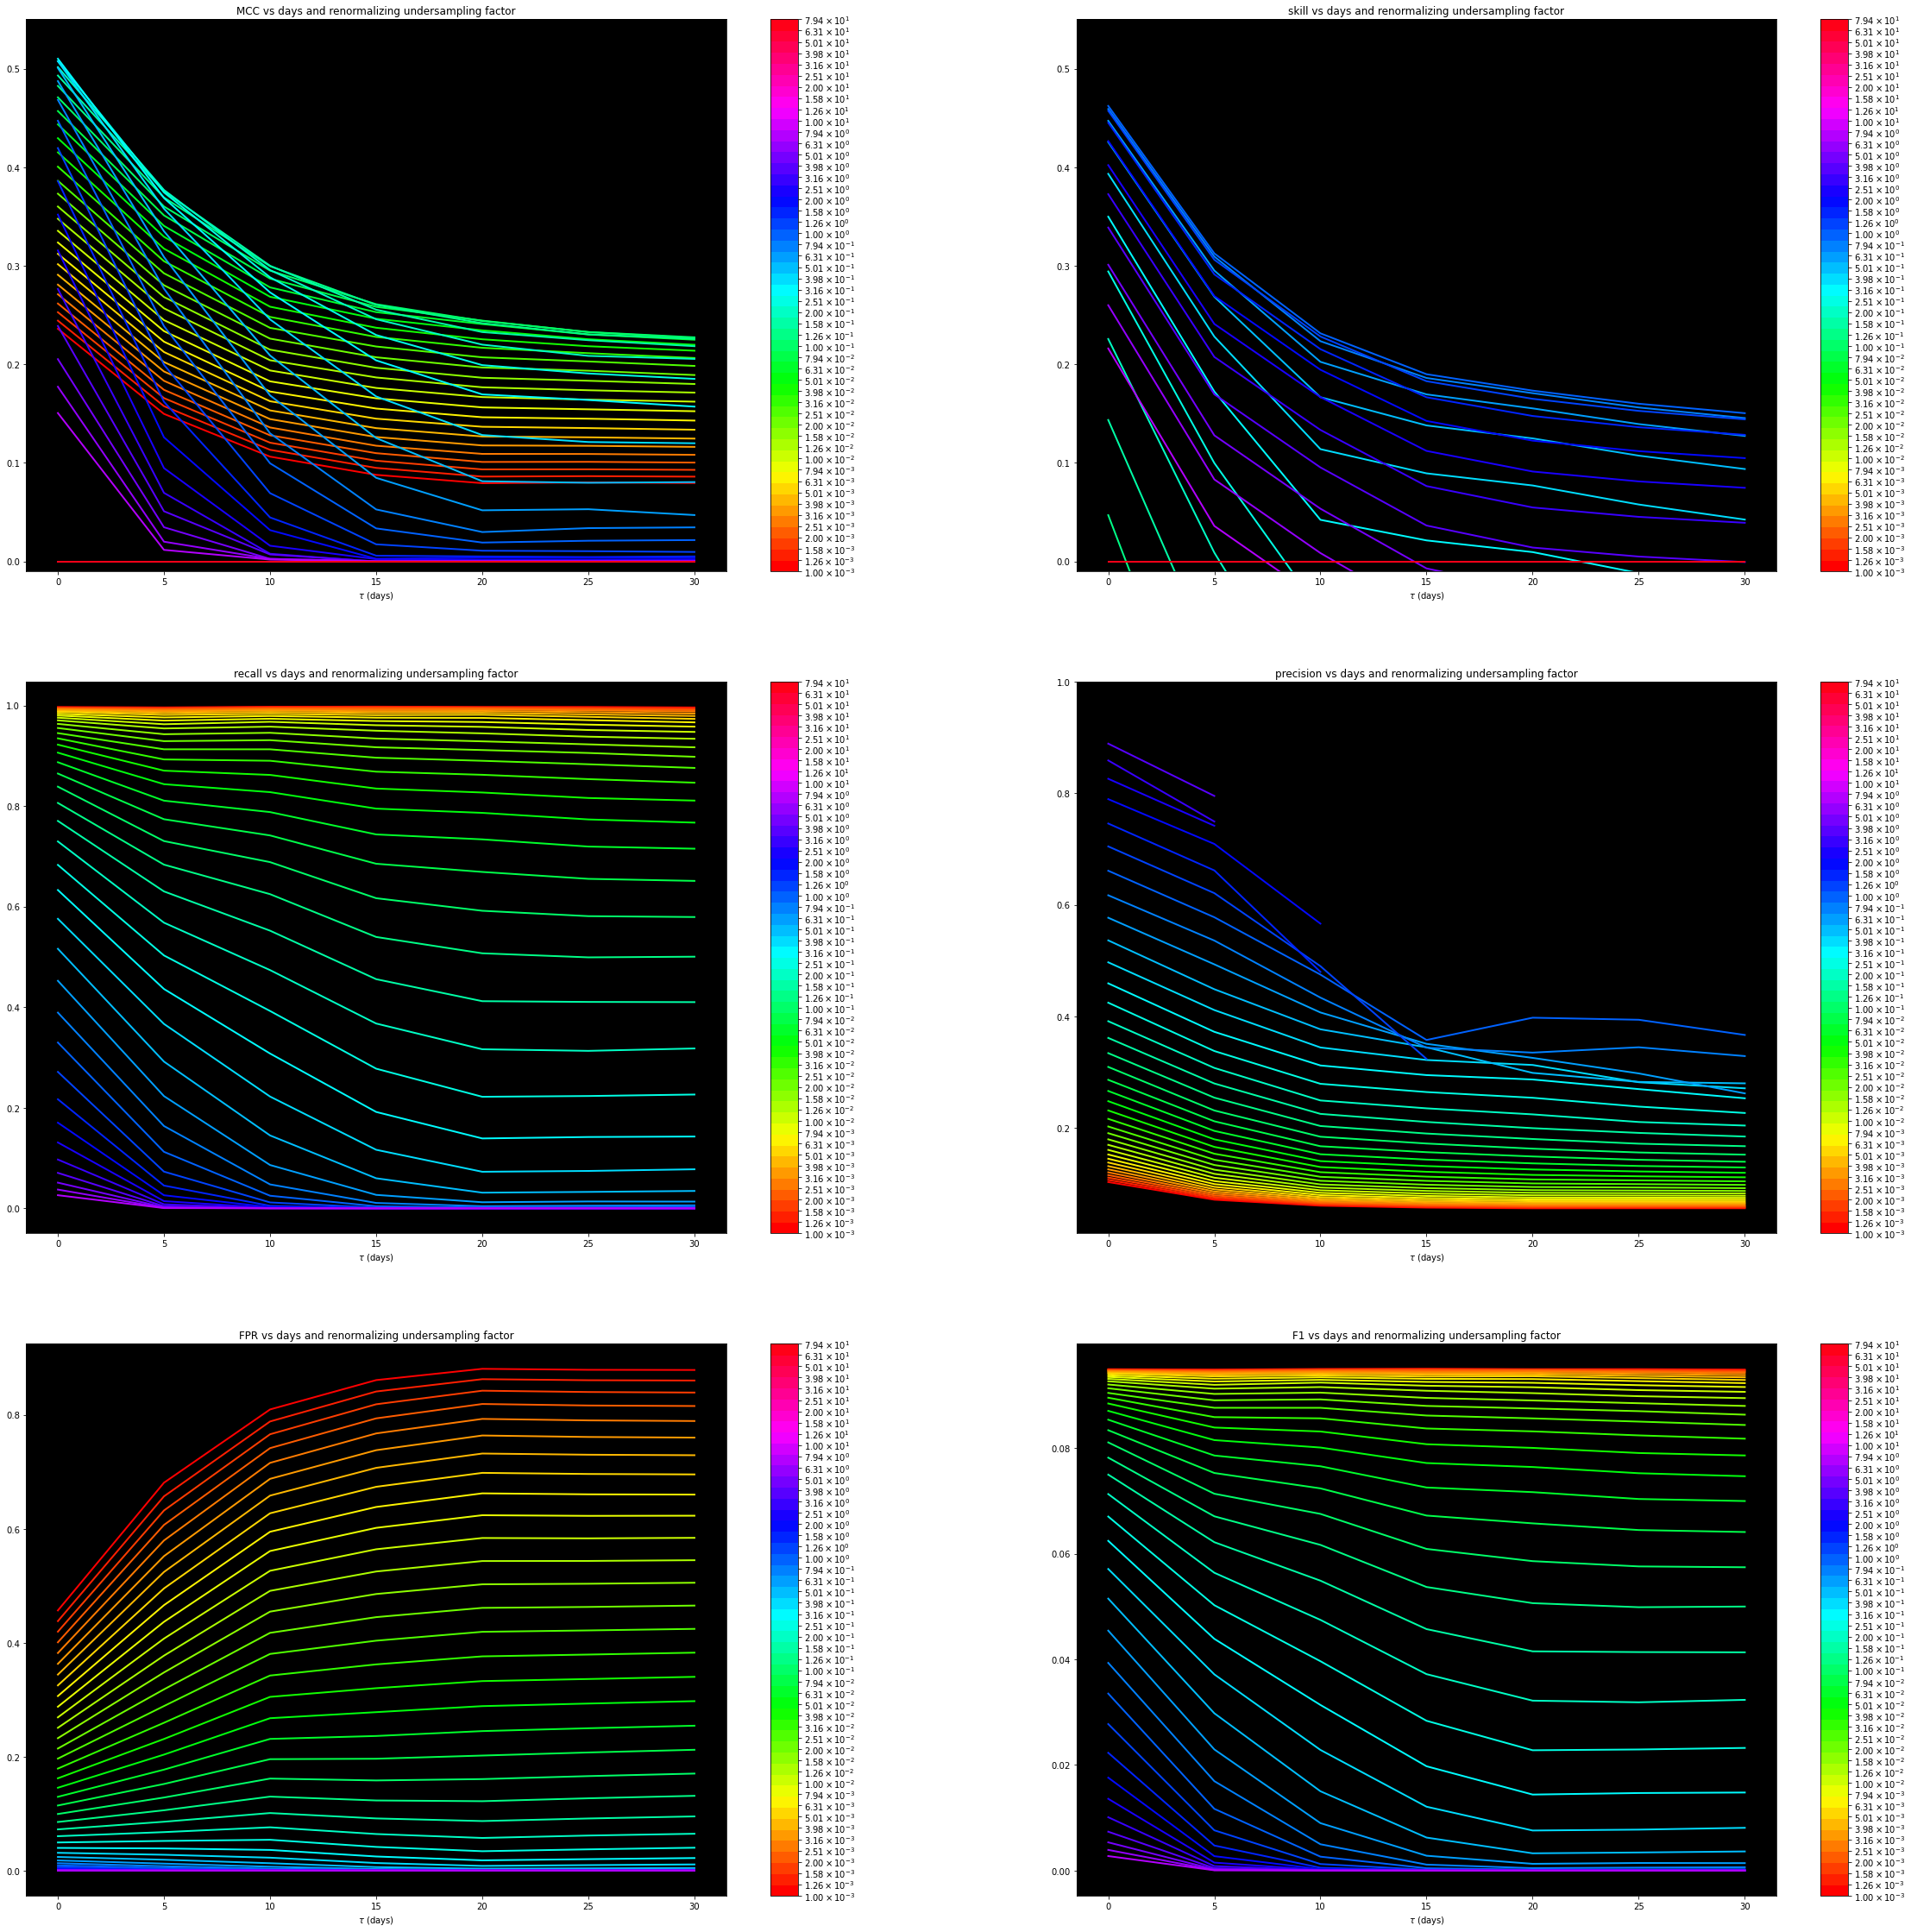

In [167]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib as mpl

def fmt(x):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

fig2 = plt.figure(figsize=(40,40))
spec2 = gridspec.GridSpec(ncols=2, nrows=3, figure=fig2)
ax = []
itrt = 0
ktrt = 0
jtrt = 0
for new_metric, metric_label in zip([new_MCC,new_skill,new_TPR, new_PPV, new_FPR, new_F1],['MCC','skill','recall','precision', 'FPR', 'F1']):
    ax.append(fig2.add_subplot(spec2[jtrt,ktrt]))
    
    print(itrt)

    colorparams = new_metric.shape[2]
    cmap = plt.get_cmap('hsv', colorparams)
    color_idx =  np.arange(0,len(undersampling_factors),1) #undersampling_factors #


    for i, iterate in enumerate(color_idx):
        ax[itrt].plot(range(0,35,5),np.mean(new_metric[:,:,i],1), c = cmap(iterate), linewidth=2)
    # Normalizer
    norm = mpl.colors.Normalize(vmin=color_idx.min(), vmax=color_idx.max())

    # creating ScalarMappable
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar = fig2.colorbar(sm, format=ticker.FuncFormatter(fmt))
    cbar.set_ticks(color_idx)
    cbar.set_ticklabels(list(map(fmt,undersampling_factors)))
    ax[itrt].set_facecolor((0, 0, 0))
    ax[itrt].set_xlabel('$\\tau$ (days)')
    ax[itrt].set_title(metric_label+' vs days and renormalizing undersampling factor')
    if jtrt==0:
        ax[itrt].set_ylim([-0.01,0.55])
    
    itrt = itrt + 1
    ktrt = ktrt + 1
    if ktrt > 1:
        ktrt = 0
        jtrt = jtrt+1